# MISO Wiener Filter

Author: Artem Basalaev <artemDOTbasalaev@pmDOTme>

Wiener filter gives an estimate of target channel from one or more references, based on linear coherence. This estimate is optimal for linear and stationary signals. The most common application is to have reference(s) for noise which enables then subtraction of this noise from target channel. More generally,  Wiener filter generates a time-domain filter that is equivalent to frequency-domain transfer function between two channels, or several such transfer functions if more than one reference is used (one per reference).

The most common Wiener filter algorithm available (e.g. in image processing etc) relies on one reference, or even no reference if noise is being estimated directly in the target channel. In other words it is a single-input, single-output Wiener filter, or sometimes the output has higher dimensionality, such as the case with filtering images (2D). The filter implemented here is MISO filter (based on algorithm in https://dcc.ligo.org/LIGO-T070192/public), where multiple references can be supplied to estimate target channel. See also `J. Harms, Terrestrial gravity fluctuations, Living Reviews in Relativity 22, 6 (2019)`.

This complicates the calculation as the matrix to invert is no longer a simple Toeplitz matrix, but a block-Toeplitz matrix. This structure however is still exploited to speed up calculation significantly compared to general matrix inversion. Implementation is based on iterative solvers from `scipy.sparse.linalg` that don't require full matrix knowledge for every iteration and `scipy.sparse.linalg.LinearOperator` to generate matrix elements based on a rule (operator), which permits exploiting symmetries of the matrix. In case of longer time series than necessary for filter generation, several filters will be generated and the best automatically selected. Application of the filter to references is also optimized using `numpy` arrays and optionally can be done with `multiprocessing`.

If not done already, install spicypy (uncomment the line below):

In [1]:
# pip install spicypy

Imports:

In [2]:
from spicypy.signal import WienerFilter
from spicypy.signal import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

## Generate data: sine waves with two main frequencies and some white noise

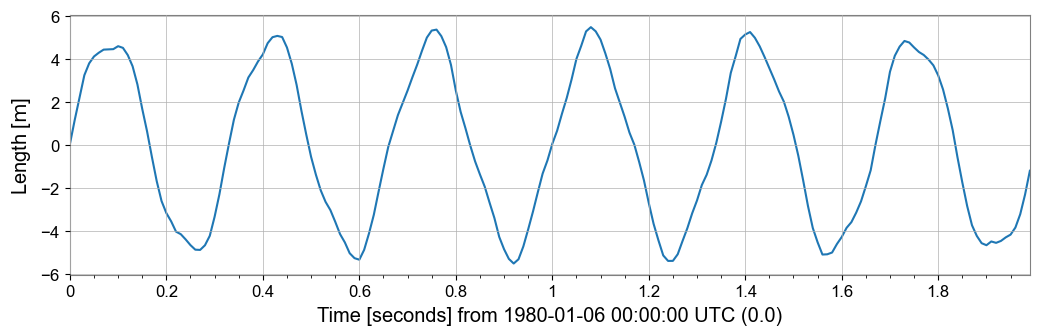

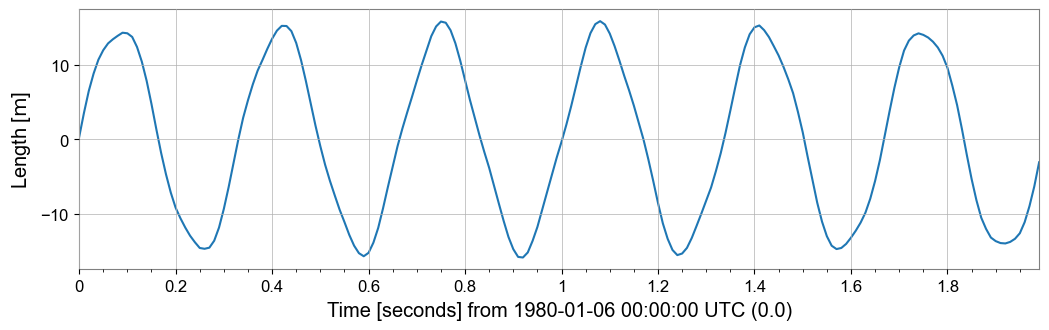

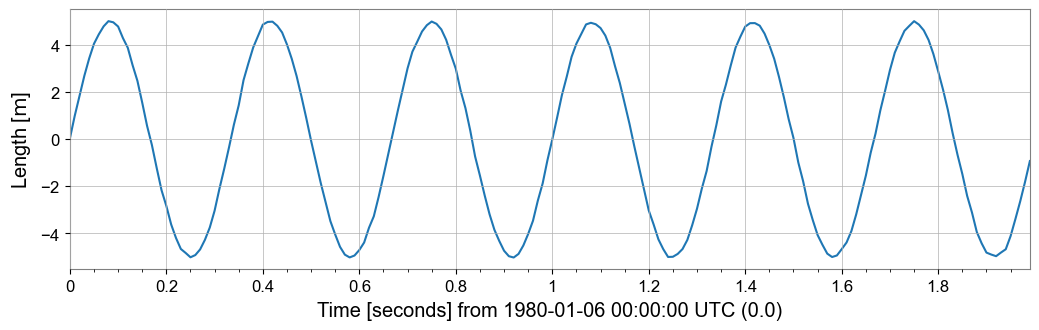

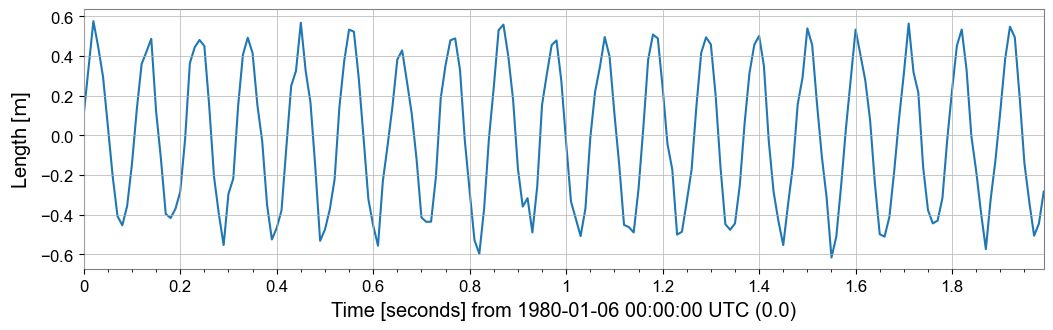

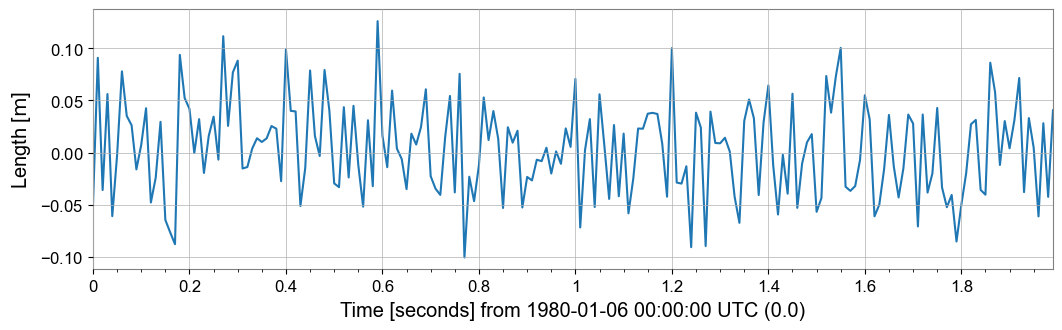

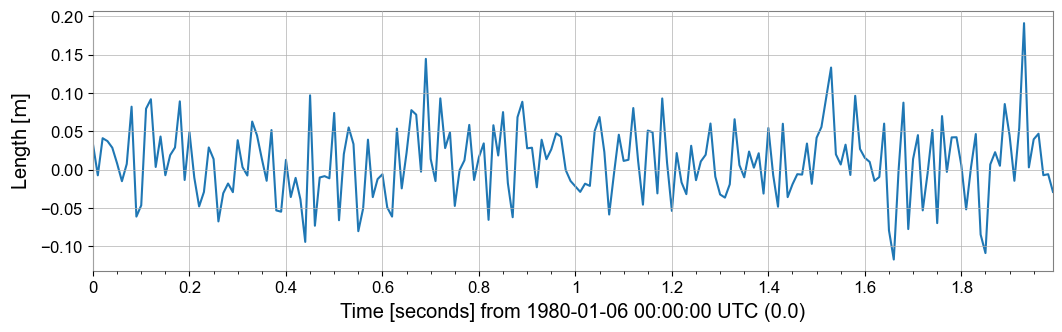

In [3]:
total_time = 1500  # in seconds, enouch to generate WF with 45 000 taps and validate it
sampling_frequency = 100  # in Hz
n_samples = total_time * sampling_frequency
total_time += (
    1.0 / sampling_frequency
)  # need an extra sample to create WF with 15 000 taps
f1 = 3  # first frequency in Hz
f2 = 9.5  # second frequency in Hz
a1 = 5.0
a2 = 0.5
noise_scale = 0.05
np.random.seed(777)
t = np.linspace(0, total_time, n_samples)

# Generate target: Signal2 - these time series will be inferred from references. Add two frequencies and a bit of white noise
s2 = (
    3 * a1 * np.sin(2 * np.pi * f1 * t)
    + 2 * a2 * np.sin(2 * np.pi * f2 * t + 0.1 * np.pi)
    + np.random.normal(0, scale=noise_scale, size=n_samples)
)
signal2 = TimeSeries(s2, sample_rate=sampling_frequency, name="Signal 2", unit="meter")

# Generate one reference with both frequencies: Signal1, at different amplitudes and with some uncorrelated white noise
s1 = (
    a1 * np.sin(2 * np.pi * f1 * t)
    + a2 * np.sin(2 * np.pi * f2 * t)
    + np.random.normal(0, scale=noise_scale, size=n_samples)
)
signal1 = TimeSeries(s1, sample_rate=sampling_frequency, name="Signal 1", unit="meter")

# Generate two references, Signal 11 and Signal 12, where each has only ONE signal frequency (with some uncorrelated white noise)
s11 = a1 * np.sin(2 * np.pi * f1 * t) + np.random.normal(
    0, scale=noise_scale, size=n_samples
)
signal11 = TimeSeries(
    s11, sample_rate=sampling_frequency, name="Signal 11", unit="meter"
)
s12 = a2 * np.sin(2 * np.pi * f2 * t) + np.random.normal(
    0, scale=noise_scale, size=n_samples
)
signal12 = TimeSeries(
    s12, sample_rate=sampling_frequency, name="Signal 12", unit="meter"
)

# Generate two other "useless" references = pure white noise, Signal 3 and Signal 4
s3 = np.random.normal(0, scale=noise_scale, size=n_samples)
signal3 = TimeSeries(s3, sample_rate=sampling_frequency, name="Signal 3", unit="meter")
s4 = np.random.normal(0, scale=noise_scale, size=n_samples)
signal4 = TimeSeries(s4, sample_rate=sampling_frequency, name="Signal 4", unit="meter")

# plot first 2 seconds
_ = signal1[0:200].plot()
_ = signal2[0:200].plot()
_ = signal11[0:200].plot()
_ = signal12[0:200].plot()
_ = signal3[0:200].plot()
_ = signal4[0:200].plot()

## Generate filters from longer time series and select the best; try 150-taps and 450-taps with different number and quality of references

In [4]:
n_taps = 150
n_samples_for_generation = (
    n_taps * 100 + 1
)  # This is enough samples for 100 filters. All 100 will be automatically generated and the best selected
# 150-taps WF with a single reference for both frequencies:
WF_1ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [signal1[0:n_samples_for_generation]],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
)
# 150-taps WF with 2 references, each for one frequency:
WF_2ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [signal11[0:n_samples_for_generation], signal12[0:n_samples_for_generation]],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
)
# 150-taps WF with single reference for both frequencies and 2 "useless" pure noise references
WF_3ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [
        signal1[0:n_samples_for_generation],
        signal3[0:n_samples_for_generation],
        signal4[0:n_samples_for_generation],
    ],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
)
# 150-taps WF with 2 references, each for one frequency and 1 "useless" pure noise reference
WF_2_plus_1ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [
        signal11[0:n_samples_for_generation],
        signal12[0:n_samples_for_generation],
        signal3[0:n_samples_for_generation],
    ],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
)
# 450-taps WF with a single reference for both frequencies:
n_taps_long = 450
n_samples_for_generation_long = (
    n_taps_long * 100 + 1
)  # This is enough samples for 100 filters. All 100 will be automatically generated and the best selected
WF_1ref_long = WienerFilter(
    signal2[0:n_samples_for_generation_long],
    [signal1[0:n_samples_for_generation_long]],
    n_taps=n_taps_long,
    normalize_data=True,
    subtract_mean=False,
)

Data is first normalized if `normalize_data=True` to be between 0 and 1 to have more reliable calculation (default).

It is done simply as `ts = std(ts-mean(ts))`. When applying filter, before time series are returned, normalization is inverted `ret_ts = ret_ts*std_ts+mean(ts)`. In the example above `subtract_mean = False` because we know that input data already had zero mean.

Filters are generated (and the best is found if more than one can be generated) by calling `create_filters`.

In [5]:
WF_1ref.create_filters()

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  16


In [6]:
WF_2ref.create_filters()

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  93


In [7]:
WF_3ref.create_filters()

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  77


In [8]:
WF_2_plus_1ref.create_filters()

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  16


In [9]:
WF_1ref_long.create_filters()

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  77


Now apply Wiener filters to data "it has never seen" - skip `n_samples_for_generation` samples which were used for generation.

With `zero_padding=True` output time series will start at the same time as input time series, but first `n_taps` elements will be zero, because WF needs to "accumulate" `n_tap` past samples to produce one output sample. 

Alternatively set `zero_padding=False` for time series where start will be shifter by `n_taps`

In [10]:
wf_1ref_signal2 = WF_1ref.apply(
    inputs_list=[signal1[n_samples_for_generation:]], zero_padding=True
)

In [11]:
wf_2ref_signal2 = WF_2ref.apply(
    inputs_list=[
        signal11[n_samples_for_generation:],
        signal12[n_samples_for_generation:],
    ],
    zero_padding=True,
)

In [12]:
wf_3ref_signal2 = WF_3ref.apply(
    inputs_list=[
        signal1[n_samples_for_generation:],
        signal3[n_samples_for_generation:],
        signal4[n_samples_for_generation:],
    ],
    zero_padding=True,
)

In [13]:
wf_2_plus_1ref_signal2 = WF_2_plus_1ref.apply(
    inputs_list=[
        signal11[n_samples_for_generation:],
        signal12[n_samples_for_generation:],
        signal3[n_samples_for_generation:],
    ],
    zero_padding=True,
)

In [14]:
wf_1ref_long_signal2 = WF_1ref_long.apply(
    inputs_list=[signal1[n_samples_for_generation_long:]], zero_padding=True
)

In [15]:
print(wf_1ref_signal2[465:485])

TimeSeries([-0.41744471,  1.87019563,  3.98198313,  6.48201613,
             8.16779246, 10.52216907, 12.46560142, 14.3527557 ,
            15.16225973, 16.09706094, 15.56997218, 14.37039977,
            12.54841477, 10.30850133,  7.60242838,  4.81944412,
             2.40814996,  0.07801253, -2.39903087, -4.49759618]
           unit: m,
           t0: 154.66 s,
           dt: 0.01 s,
           name: Wiener filter output,
           channel: None)


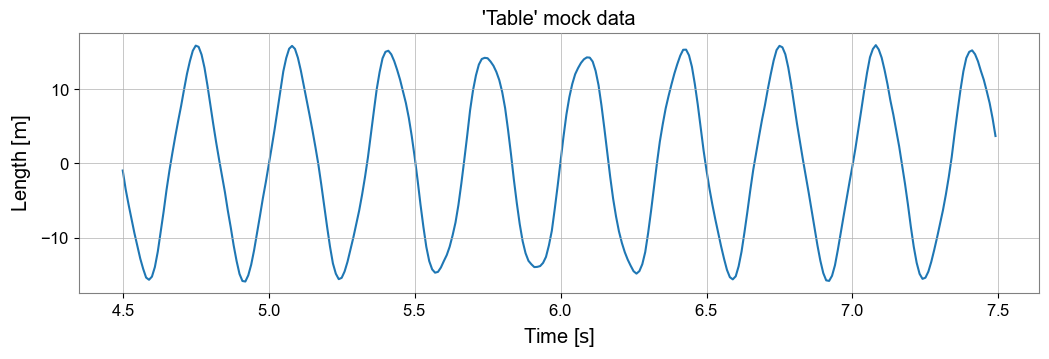

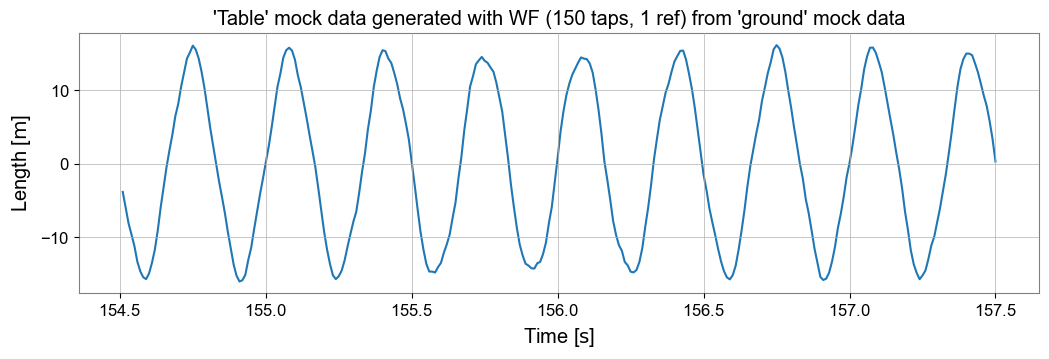

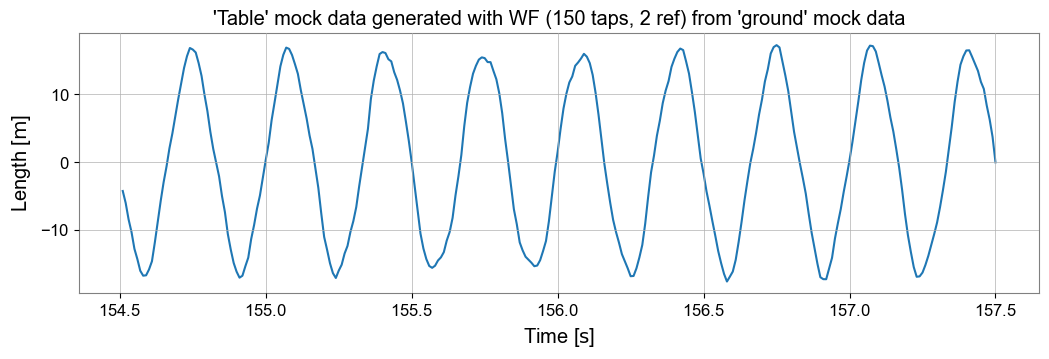

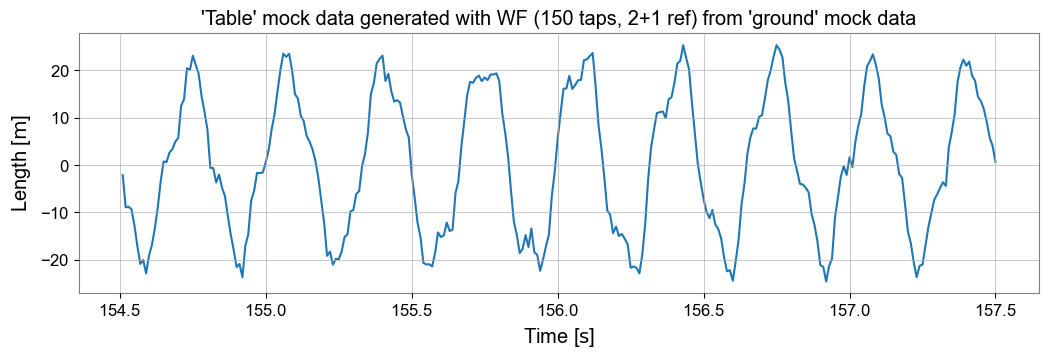

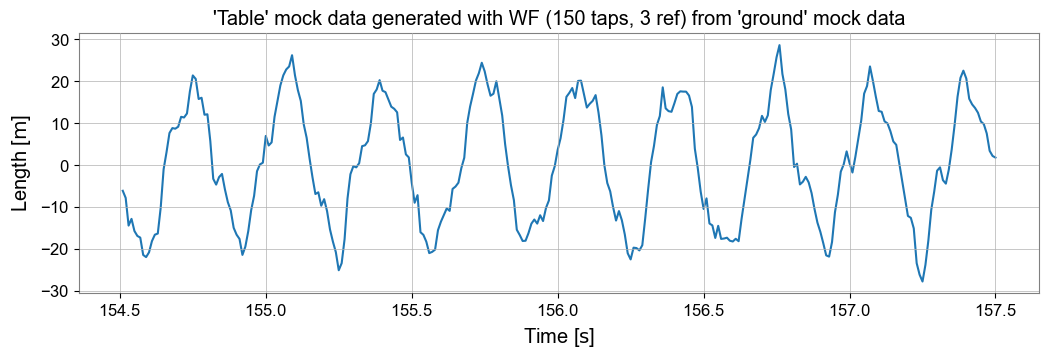

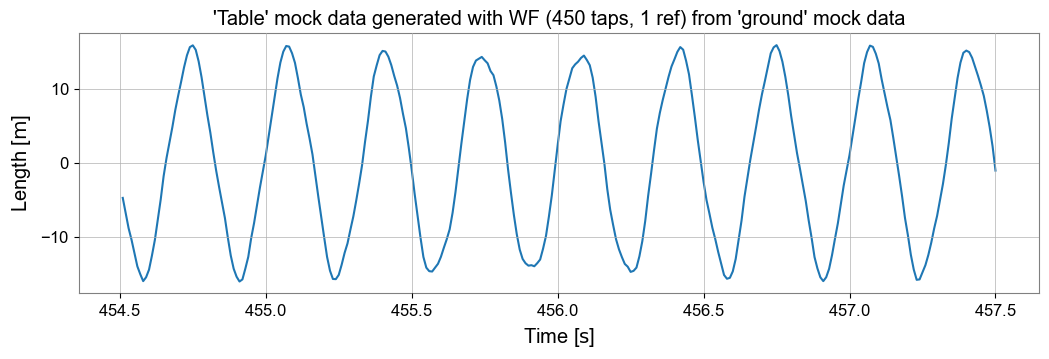

In [16]:
plt.rcParams["figure.figsize"] = [10, 3]
_ = signal2[450:750].plot(title="'Table' mock data", xscale="linear")
plt.savefig("300_taps_mock_data.png")
_ = wf_1ref_signal2[450:750].plot(
    title="'Table' mock data generated with WF (150 taps, 1 ref) from 'ground' mock data",
    xscale="linear",
)
plt.savefig("WF_150_taps_1ref_for_300_taps_mock_data.png")
_ = wf_2ref_signal2[450:750].plot(
    title="'Table' mock data generated with WF (150 taps, 2 ref) from 'ground' mock data",
    xscale="linear",
)
plt.savefig("WF_150_taps_2ref_for_300_taps_mock_data.png")
_ = wf_2_plus_1ref_signal2[450:750].plot(
    title="'Table' mock data generated with WF (150 taps, 2+1 ref) from 'ground' mock data",
    xscale="linear",
)
plt.savefig("WF_150_taps_2_plus_1ref_for_300_taps_mock_data.png")
_ = wf_3ref_signal2[450:750].plot(
    title="'Table' mock data generated with WF (150 taps, 3 ref) from 'ground' mock data",
    xscale="linear",
)
plt.savefig("WF_150_taps_3ref_for_300_taps_mock_data.png")
_ = wf_1ref_long_signal2[450:750].plot(
    title="'Table' mock data generated with WF (450 taps, 1 ref) from 'ground' mock data",
    xscale="linear",
)
plt.savefig("WF_450_taps_1ref_for_300_taps_mock_data.png")

It is already visible that noisy "useless" references "confuse" Wiener filter quite a lot. Notably the 450-taps WF has ~same matrix size to invert as 150-taps filter with 3 references, so it is not simply an issue with larger matrix.

The effect is even more obvious on a spectrum (ASD). Use 450s for each ASD to9 make a uniform comparison

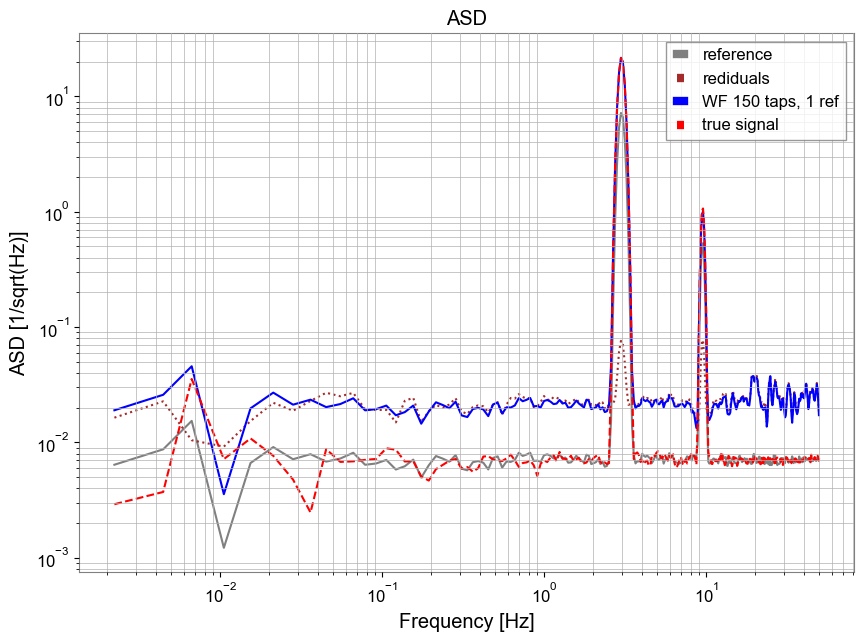

In [17]:
plt.rcParams["figure.figsize"] = [10, 7]

plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_signal2[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_signal2[-45000:].asd(method="lpsd"),
    label="WF 150 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_150_taps_1ref_for_mock_data_ADS.png")

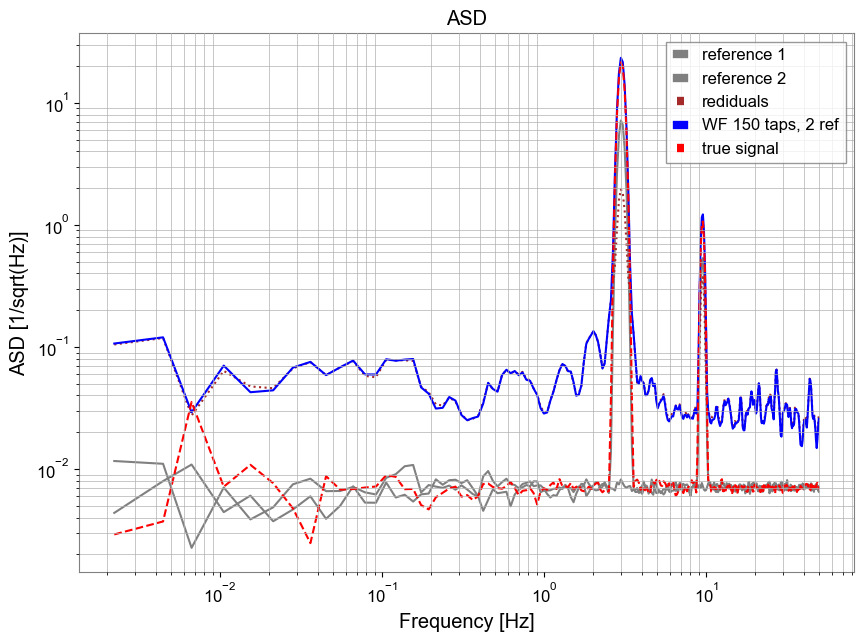

In [18]:
plt.loglog(signal11[-45000:].asd(method="lpsd"), label="reference 1", color="gray")
plt.loglog(signal12[-45000:].asd(method="lpsd"), label="reference 2", color="gray")
plt.loglog(
    (wf_2ref_signal2[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_2ref_signal2[-45000:].asd(method="lpsd"),
    label="WF 150 taps, 2 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_150_taps_2ref_for_mock_data_ADS.png")

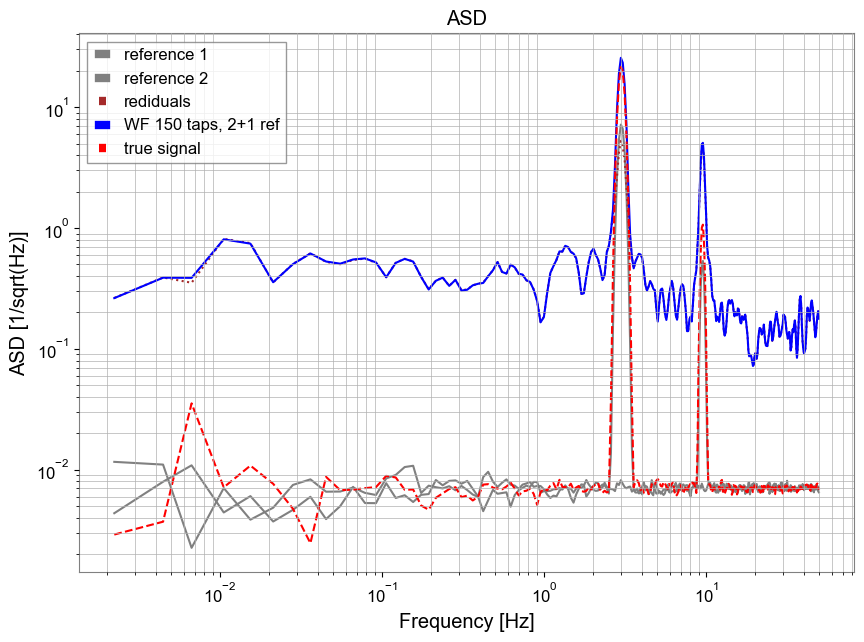

In [19]:
plt.loglog(signal11[-45000:].asd(method="lpsd"), label="reference 1", color="gray")
plt.loglog(signal12[-45000:].asd(method="lpsd"), label="reference 2", color="gray")
plt.loglog(
    (wf_2_plus_1ref_signal2[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_2_plus_1ref_signal2[-45000:].asd(method="lpsd"),
    label="WF 150 taps, 2+1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_150_taps_2_plus_1ref_for_mock_data_ADS.png")

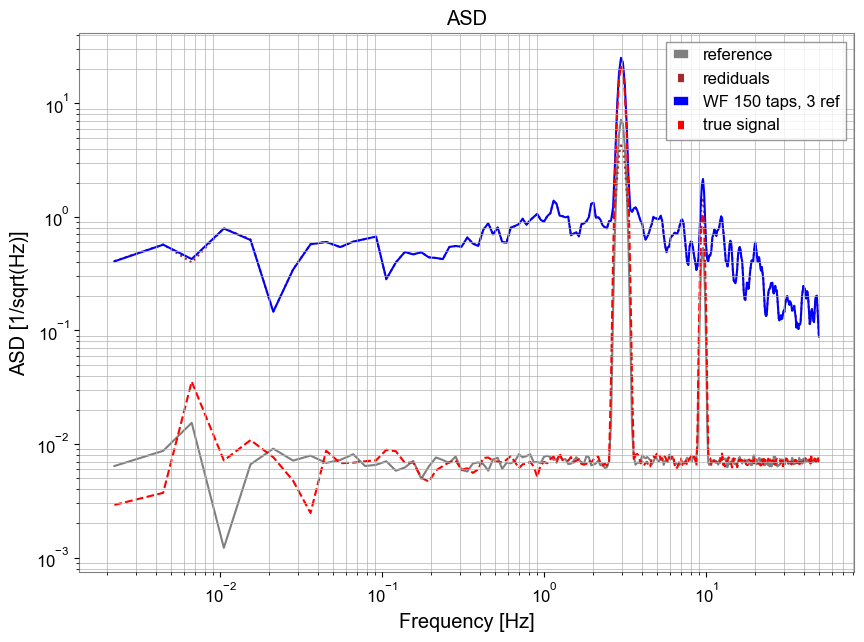

In [20]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_3ref_signal2[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_3ref_signal2[-45000:].asd(method="lpsd"),
    label="WF 150 taps, 3 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_150_taps_3ref_for_mock_data_ADS.png")

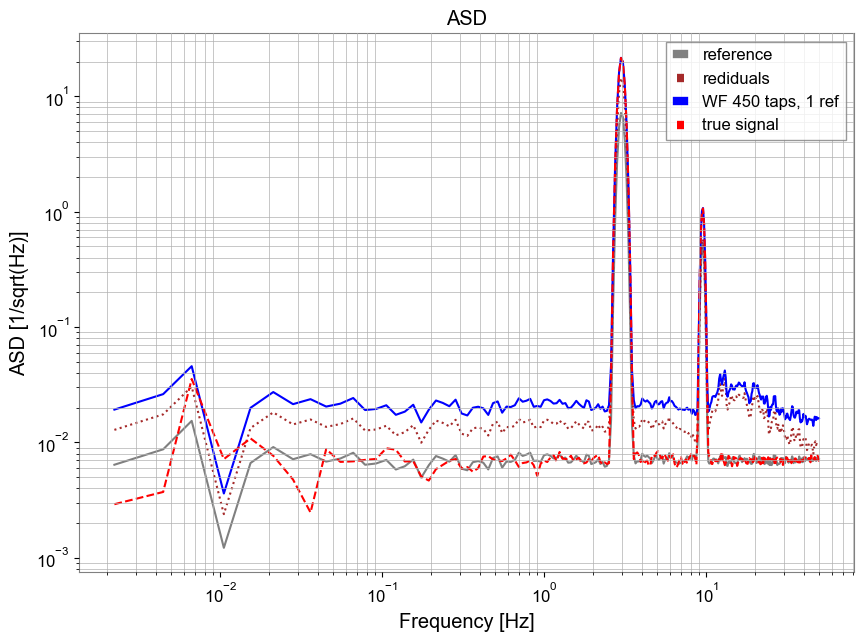

In [21]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_long_signal2[-45000:] - signal1[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_long_signal2[-45000:].asd(method="lpsd"),
    label="WF 450 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_450_taps_1ref_for_mock_data_ADS.png")

It is visible that performance of a 450-taps WF is similar to that of 150-taps with one reference. The noise floor for 450-taps filter is smaller (as visible from smaller residuals). Increasing number of references increases the noise, which is visibly higher for 150-taps 2-reference case. In case of "useless" references, noise starts to dominate, "confusing" WF, with error also appearing in peaks estimation. The effect is visible in 150-taps 2 "good" references + 1 noisy case, and even more drastic with 2 "noisy" references.

## Save and load Wiener filters

Generated Wiener filters can be saved in `json` format to applied later or to different data.

In [22]:
WF_1ref_long.save("WF_1ref_long.json")

Load the same filter and apply it:

In [23]:
WF_1ref_long_load = WienerFilter.load("WF_1ref_long.json")
wf_1ref_long_load_signal2 = WF_1ref_long_load.apply(
    inputs_list=[signal1[n_samples_for_generation_long:]], zero_padding=True
)

Check with the plot that result is still the same

Text(0, 0.5, 'ASD [1/sqrt(Hz)]')

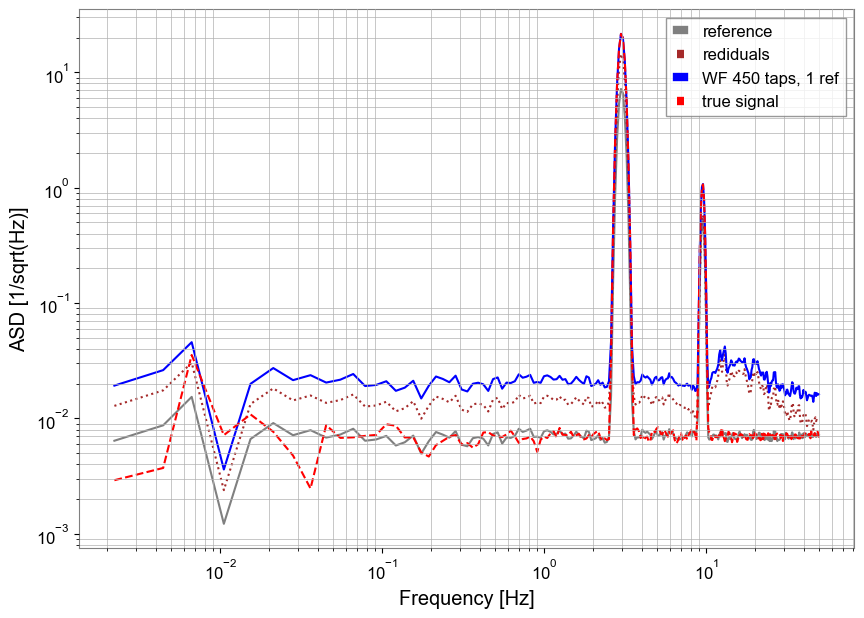

In [24]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_long_load_signal2[-45000:] - signal1[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_long_load_signal2[-45000:].asd(method="lpsd"),
    label="WF 450 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")

## Use different iterative solvers for Wiener-Hopf equations

You can choose between following iterative solvers from `scipy.sparse.linalg`: "gmres", "cgs", "cg", "gcrotmk","tfqmr", "bicgstab", "lgmres", "minres". Default solver is "tfqmr". See [scipy.sparse.linalg](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems) for more information on specific differences between solver algorithms. In practice, using different solver may affect "noise floor" for specific problem. Let's see how the result for 1-reference 150-taps Wiener filter changes with "gmres" solver:

In [25]:
WF_1ref_gmres = WienerFilter(
    signal2[0:n_samples_for_generation],
    [signal1[0:n_samples_for_generation]],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
    solver="gmres",
)
WF_1ref_gmres.create_filters()
wf_1ref_gmres_signal2 = WF_1ref_gmres.apply(
    inputs_list=[signal1[n_samples_for_generation:]], zero_padding=True
)

Creating Wiener Filters...
Determining the best filter...
Done. Best filter index:  16


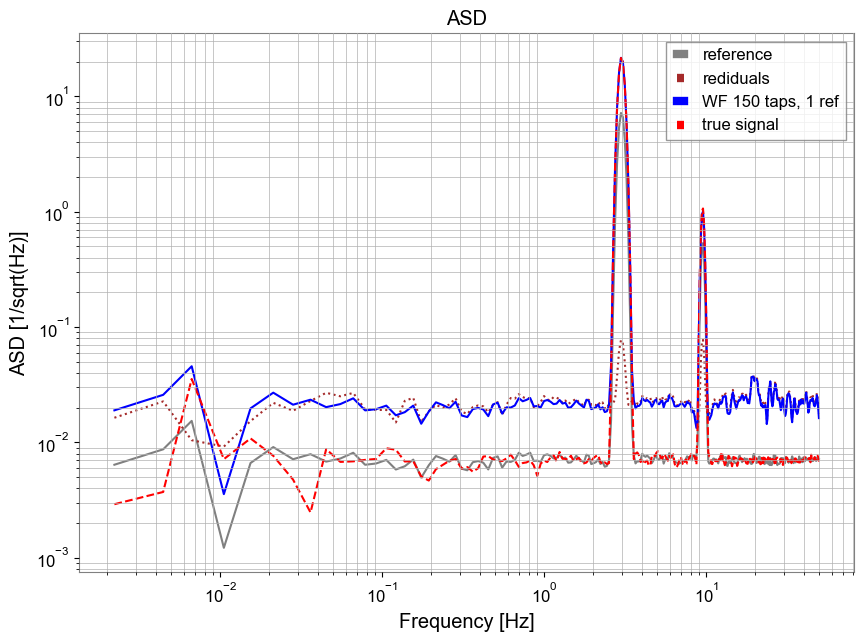

In [26]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_gmres_signal2[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_gmres_signal2[-45000:].asd(method="lpsd"),
    label="WF 150 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_150_taps_1ref_gmres_for_mock_data_ADS.png")

## Try 15 000 and 45 000 taps Wiener filters

In [27]:
n_taps = 15000
n_samples_for_generation = (
    n_taps + 1
)  # in this case, to save time, generate just one WF
WF_monster_1ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [signal1[0:n_samples_for_generation]],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
    verbose=True,
)
WF_monster_2ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [signal11[0:n_samples_for_generation], signal12[0:n_samples_for_generation]],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
    verbose=True,
)
WF_monster_3ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [
        signal1[0:n_samples_for_generation],
        signal3[0:n_samples_for_generation],
        signal4[0:n_samples_for_generation],
    ],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
    verbose=True,
)
WF_monster_2_plus_1ref = WienerFilter(
    signal2[0:n_samples_for_generation],
    [
        signal11[0:n_samples_for_generation],
        signal12[0:n_samples_for_generation],
        signal3[0:n_samples_for_generation],
    ],
    n_taps=n_taps,
    normalize_data=True,
    subtract_mean=False,
    verbose=True,
)
n_taps_long = 45000
n_samples_for_generation_long = (
    n_taps_long + 1
)  # in this case, to save time, generate just one WF
WF_monster_1ref_long = WienerFilter(
    signal2[0:n_samples_for_generation_long],
    [signal1[0:n_samples_for_generation_long]],
    n_taps=n_taps_long,
    normalize_data=True,
    subtract_mean=False,
    verbose=True,
)

C:\Users\basalaea\.conda\envs\old\lib\site-packages\spicypy\signal\wiener_filter.py:245: UserWarning: Creating Wiener filter with 15000 or more taps requested. This is A LOT. Depending on number of references and available resources, calculation may fail!
  warn(


With `verbose=True` each stage of filter generation will be shown, as well as of selecting the best filter. The latter won't show up now because there's only enough taps for one filter, as defined above

In [28]:
WF_monster_1ref.create_filters()

Creating Wiener filter:  0
calculating R00
calculating cross-corr vector
inverting the matrix


In [29]:
WF_monster_2ref.create_filters()

Creating Wiener filter:  0
calculating R00
calculating R01
calculating R11
calculating cross-corr vector
inverting the matrix


Note: 3-reference filter and 45 000 - taps filter below will take significantly longer as matrix size grows as square of n_taps and n_refs.

In [30]:
WF_monster_3ref.create_filters()

Creating Wiener filter:  0
calculating R00
calculating R01
calculating R02
calculating R11
calculating R12
calculating R22
calculating cross-corr vector
inverting the matrix


In [31]:
WF_monster_2_plus_1ref.create_filters()

Creating Wiener filter:  0
calculating R00
calculating R01
calculating R02
calculating R11
calculating R12
calculating R22
calculating cross-corr vector
inverting the matrix


In [32]:
WF_monster_1ref_long.create_filters()

Creating Wiener filter:  0
calculating R00
calculating cross-corr vector
inverting the matrix


In [33]:
wf_1ref_signal2_m = WF_monster_1ref.apply(
    inputs_list=[signal1[n_samples_for_generation:]], zero_padding=True
)

Dividing ref0 by std= 3.553390913174657
Applying filter 0: step 35000 out of 119999
Applying filter 0: step 85000 out of 119999
Multiplying by test std= 10.629283155281598


In [34]:
wf_2ref_signal2_m = WF_monster_2ref.apply(
    inputs_list=[
        signal11[n_samples_for_generation:],
        signal12[n_samples_for_generation:],
    ],
    zero_padding=True,
)

Dividing ref0 by std= 3.535337248795817
Dividing ref1 by std= 0.35679747230457437
Applying filter 0: step 35000 out of 119999
Applying filter 0: step 85000 out of 119999
Multiplying by test std= 10.629283155281598


To speed up applying very large filters, it is possible to use multiprocessing with `use_multiprocessing=True`. Although it does not always work faster, because, depending on architecture, numpy methods may already use some multiprocessing internally.

In [35]:
wf_3ref_signal2_m = WF_monster_3ref.apply(
    inputs_list=[
        signal1[n_samples_for_generation:],
        signal3[n_samples_for_generation:],
        signal4[n_samples_for_generation:],
    ],
    zero_padding=True,
    use_multiprocessing=True,
)

Dividing ref0 by std= 3.553390913174657
Dividing ref1 by std= 0.049610350697078316
Dividing ref2 by std= 0.04990060854201938
Using multiprocessing. Your computer may become unresponsive due to load, this is expected. Please wait until the operation is complete.
Multiplying by test std= 10.629283155281598


In [36]:
wf_2_plus_1ref_signal2_m = WF_monster_2_plus_1ref.apply(
    inputs_list=[
        signal11[n_samples_for_generation:],
        signal12[n_samples_for_generation:],
        signal3[n_samples_for_generation:],
    ],
    zero_padding=True,
    use_multiprocessing=True,
)

Dividing ref0 by std= 3.535337248795817
Dividing ref1 by std= 0.35679747230457437
Dividing ref2 by std= 0.049610350697078316
Using multiprocessing. Your computer may become unresponsive due to load, this is expected. Please wait until the operation is complete.
Multiplying by test std= 10.629283155281598


In [37]:
wf_1ref_long_signal2_m = WF_monster_1ref_long.apply(
    inputs_list=[signal1[n_samples_for_generation_long:]], zero_padding=True
)

Dividing ref0 by std= 3.5536726489848807
Applying filter 0: step 5000 out of 59999
Applying filter 0: step 55000 out of 59999
Multiplying by test std= 10.62988574008935


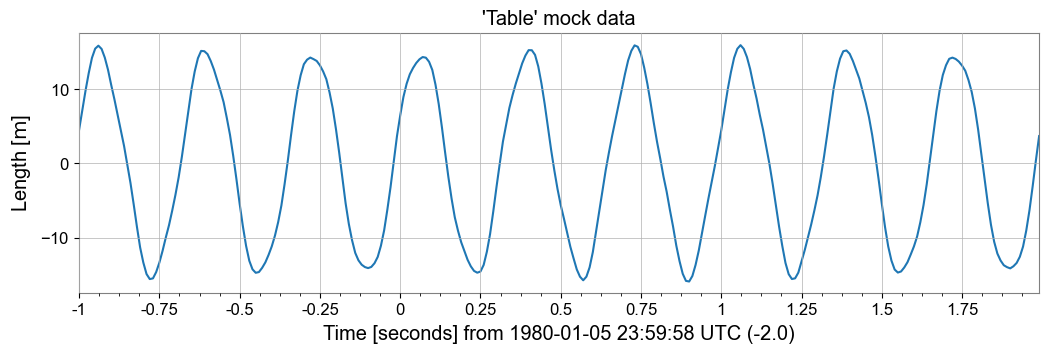

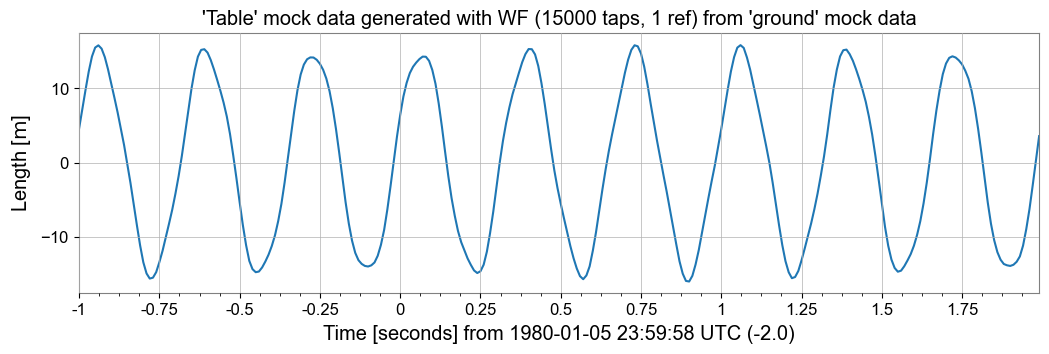

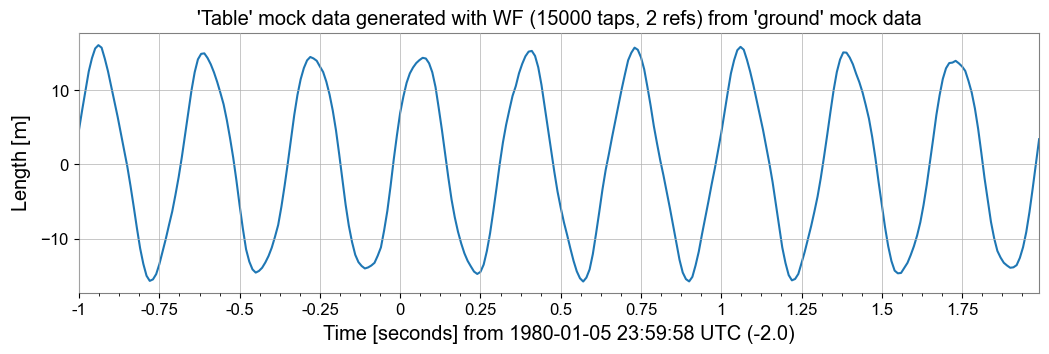

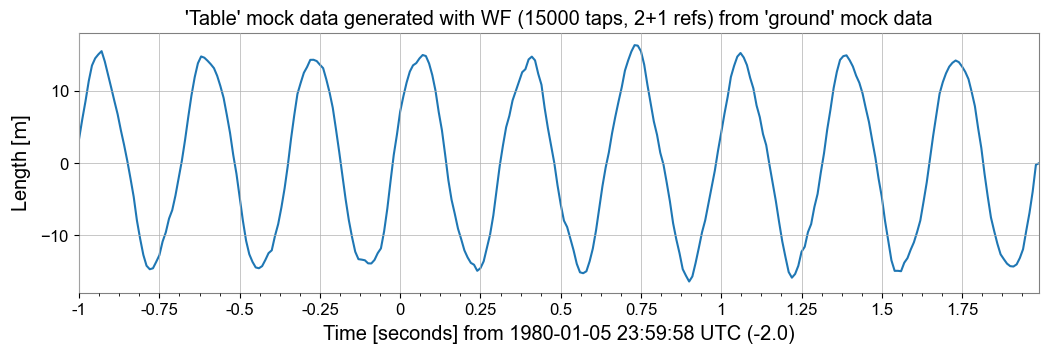

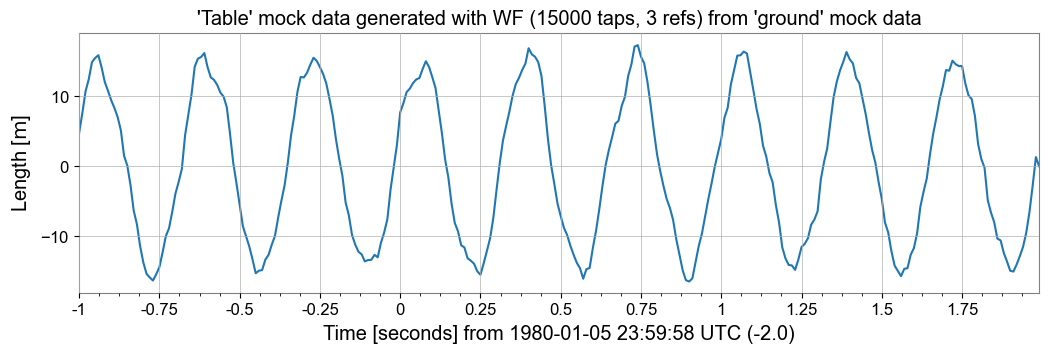

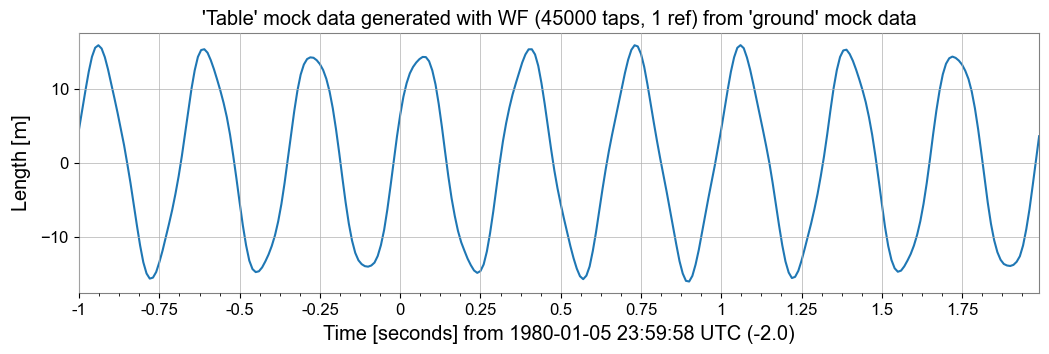

In [38]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 3]
_ = signal2[-300:].plot(title="'Table' mock data")
plt.savefig("300_taps_mock_data2.png")
wf_1ref_signal2_m_cropped = wf_1ref_signal2_m[-300:]
wf_1ref_signal2_m_cropped.t0 = -3.0
_ = wf_1ref_signal2_m_cropped.plot(
    title="'Table' mock data generated with WF (15000 taps, 1 ref) from 'ground' mock data"
)
plt.savefig("WF_15000_taps_1ref_for_300_samples_mock_data.png")
wf_2ref_signal2_m_cropped = wf_2ref_signal2_m[-300:]
wf_2ref_signal2_m_cropped.t0 = -3.0
_ = wf_2ref_signal2_m_cropped.plot(
    title="'Table' mock data generated with WF (15000 taps, 2 refs) from 'ground' mock data"
)
plt.savefig("WF_15000_taps_2ref_for_300_samples_mock_data.png")
wf_2_plus_1ref_signal2_m_cropped = wf_2_plus_1ref_signal2_m[-300:]
wf_2_plus_1ref_signal2_m_cropped.t0 = -3.0
_ = wf_2_plus_1ref_signal2_m_cropped.plot(
    title="'Table' mock data generated with WF (15000 taps, 2+1 refs) from 'ground' mock data"
)
plt.savefig("WF_15000_taps_2_plus_1ref_for_300_samples_mock_data.png")
wf_3ref_signal2_m_cropped = wf_3ref_signal2_m[-300:]
wf_3ref_signal2_m_cropped.t0 = -3.0
_ = wf_3ref_signal2_m_cropped.plot(
    title="'Table' mock data generated with WF (15000 taps, 3 refs) from 'ground' mock data"
)
plt.savefig("WF_15000_taps_3ref_for_300_samples_mock_data.png")
wf_1ref_long_signal2_m_cropped = wf_1ref_long_signal2_m[-300:]
wf_1ref_long_signal2_m_cropped.t0 = -3.0
_ = wf_1ref_long_signal2_m_cropped.plot(
    title="'Table' mock data generated with WF (45000 taps, 1 ref) from 'ground' mock data"
)
plt.savefig("WF_45000_taps_1ref_for_300_samples_mock_data.png")

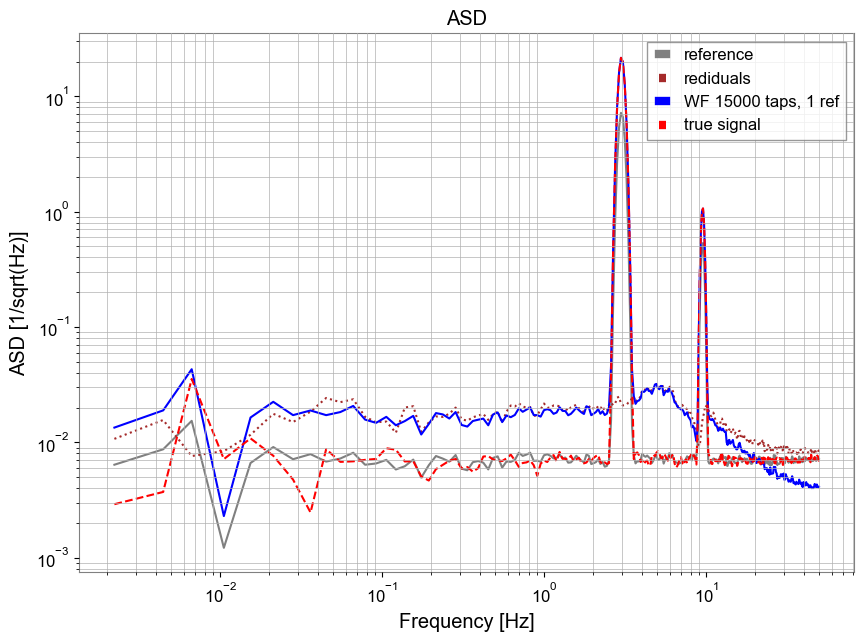

In [39]:
plt.rcParams["figure.figsize"] = [10, 7]

plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_signal2_m[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_signal2_m[-45000:].asd(method="lpsd"),
    label="WF 15000 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_15000_taps_1ref_for_mock_data_ADS.png")

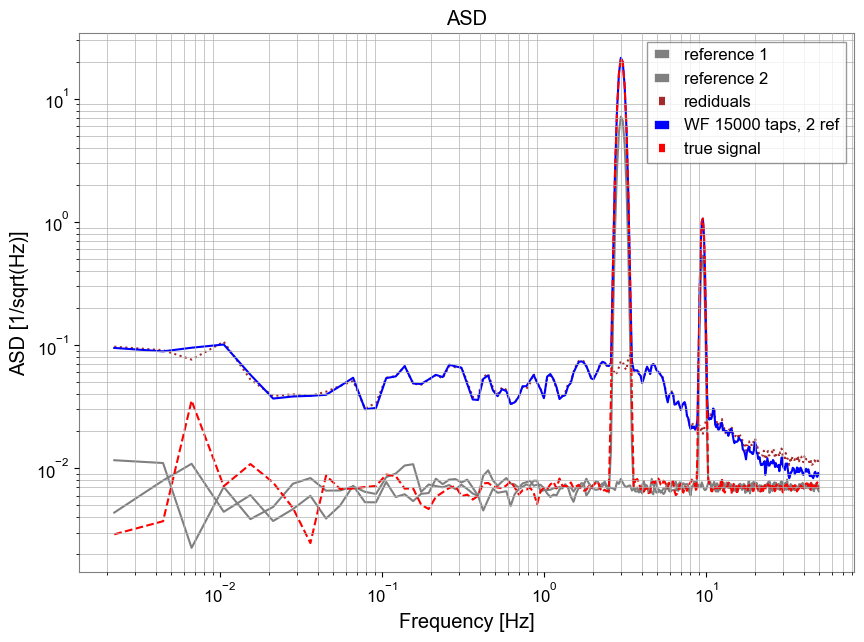

In [40]:
plt.loglog(signal11[-45000:].asd(method="lpsd"), label="reference 1", color="gray")
plt.loglog(signal12[-45000:].asd(method="lpsd"), label="reference 2", color="gray")
plt.loglog(
    (wf_2ref_signal2_m[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_2ref_signal2_m[-45000:].asd(method="lpsd"),
    label="WF 15000 taps, 2 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_15000_taps_2ref_for_mock_data_ADS.png")

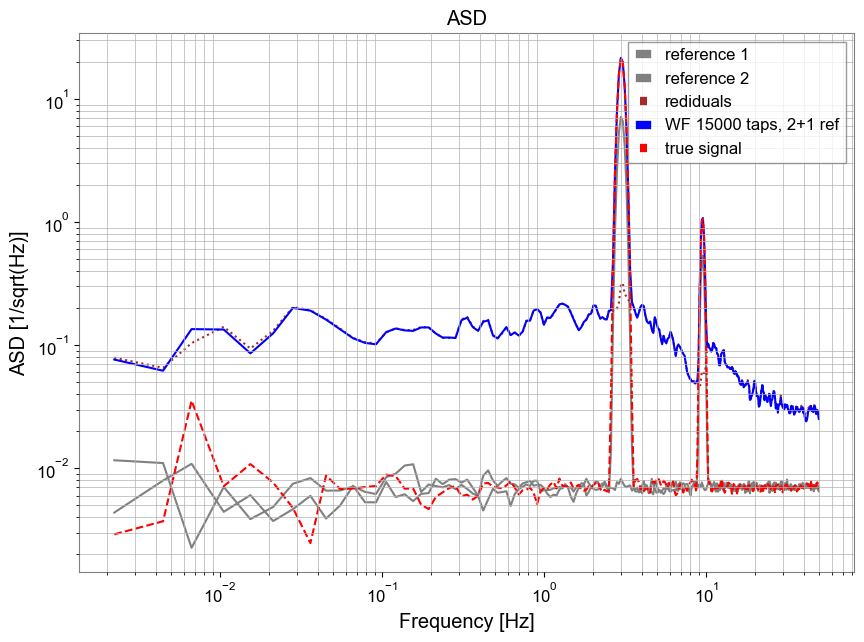

In [41]:
plt.loglog(signal11[-45000:].asd(method="lpsd"), label="reference 1", color="gray")
plt.loglog(signal12[-45000:].asd(method="lpsd"), label="reference 2", color="gray")
plt.loglog(
    (wf_2_plus_1ref_signal2_m[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_2_plus_1ref_signal2_m[-45000:].asd(method="lpsd"),
    label="WF 15000 taps, 2+1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_15000_taps_2_plus_1ref_for_mock_data_ADS.png")

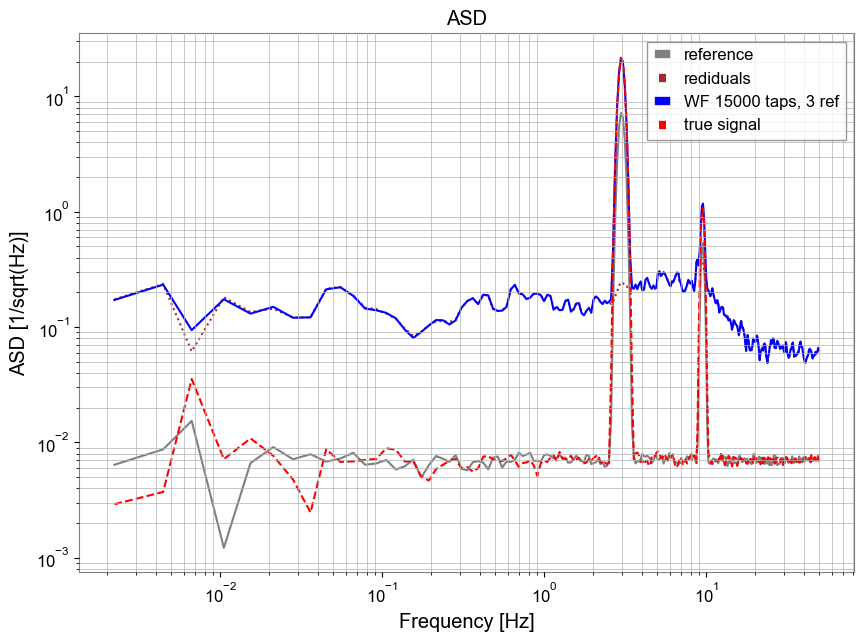

In [42]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_3ref_signal2_m[-45000:] - signal2[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_3ref_signal2_m[-45000:].asd(method="lpsd"),
    label="WF 15000 taps, 3 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_15000_taps_3ref_for_mock_data_ADS.png")

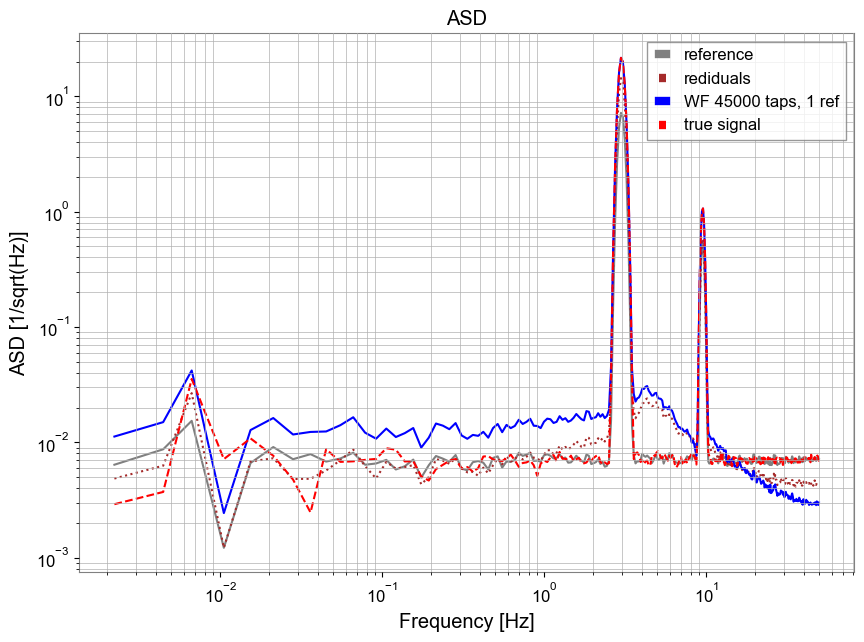

In [43]:
plt.loglog(signal1[-45000:].asd(method="lpsd"), label="reference", color="gray")
plt.loglog(
    (wf_1ref_long_signal2_m[-45000:] - signal1[-45000:]).asd(method="lpsd"),
    label="rediduals",
    color="brown",
    linestyle="dotted",
)
plt.loglog(
    wf_1ref_long_signal2_m[-45000:].asd(method="lpsd"),
    label="WF 45000 taps, 1 ref",
    color="blue",
)
plt.loglog(
    signal2[-45000:].asd(method="lpsd"),
    label="true signal",
    color="red",
    linestyle="dashed",
)

plt.grid(which="both")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/sqrt(Hz)]")
plt.title("ASD")
plt.savefig("WF_45000_taps_1ref_for_mock_data_ADS.png")

For long (large number of taps) filters, same dynamics is observed as for short filters. Performance of a 45000-taps WF is similar to that of 15000-taps with one reference, except for slightly lower noise for the former. Increasing number of references increases the noise, which is visibly higher for 15000-taps 2-reference case. Noise is even higher in case of "useless" references and is increasing with their number (visible for 15 000 taps 2 "good" + 1 noisy and 1 good + 2 "noisy" reference filters), however with so many taps WF is able to estimate correlations better and therefore noise increase is not so detrimental as in case of short filters.